In [ ]:
# Cell 1: Install Required Libraries
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/facebookresearch/segment-anything-2.git
!pip install opencv-python==4.7.0.72 numpy==1.23.5 Pillow==9.3.0 matplotlib==3.7.1 pycocotools==2.0.6 scipy==1.10.1 timm==0.6.13 onnxruntime-gpu==1.15.0 onnx==1.14.0

# Cell 2: Download SAM2 Model Weights
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -O /content/sam2_hiera_large.pt

# Cell 3: Import Required Libraries
import os
import torch
import numpy as np
import cv2
from sam2.build_sam import build_sam2_video_predictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import logging


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp311-cp311-linux_x86_64.whl (2267.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp311-cp311-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1
    Uninstalling torchvision-0.20.1:
      Successfully uninstalled torchvision-0.20.1
ERROR: pip's dependency resolver does not currently take into account all t

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

<IPython.core.display.Javascript object>

frame loading (JPEG): 100%|██████████| 1/1 [00:00<00:00, 32.87it/s]


<IPython.core.display.Javascript object>

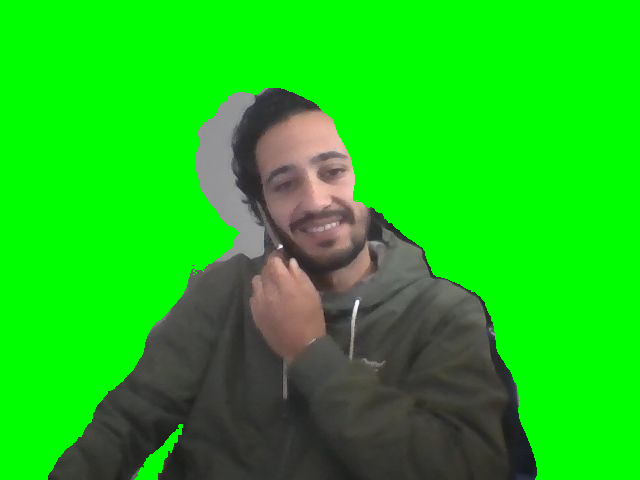

<IPython.core.display.Javascript object>

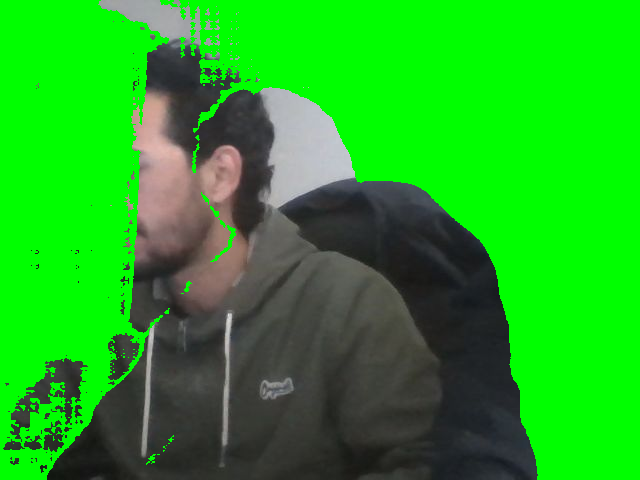

<IPython.core.display.Javascript object>

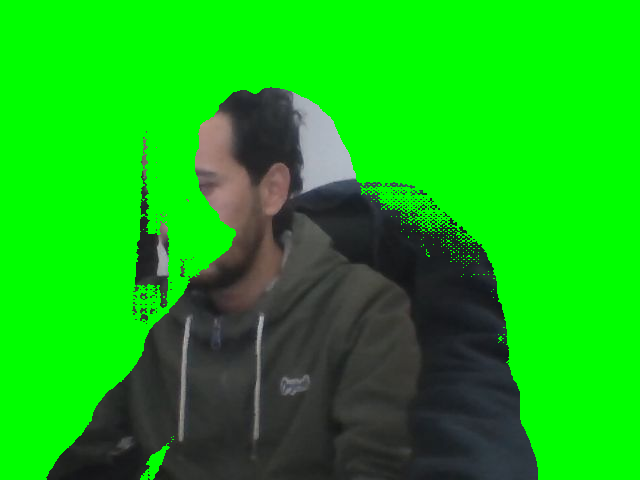

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
# Cell 4: Define the Predictor Class
class Predictor:
    def setup(self):
        logging.basicConfig(level=logging.DEBUG)
        logging.info("Starting setup")

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logging.info(f"Using device: {self.device}")

        if self.device == "cuda":
            torch.cuda.empty_cache()
            torch.autocast(device_type="cuda", dtype=torch.float16).__enter__()

        self.checkpoint = "/content/sam2_hiera_large.pt"
        self.model_cfg = "sam2_hiera_l.yaml"

        try:
            self.predictor = build_sam2_video_predictor(self.model_cfg, self.checkpoint)
            logging.info("SAM2 predictor built successfully")
        except Exception as e:
            logging.exception(f"Error building SAM2 predictor: {e}")
            raise

        # Load a pre-trained Faster R-CNN model for body detection
        self.body_detector = fasterrcnn_resnet50_fpn(pretrained=True)
        self.body_detector.eval()
        self.body_detector.to(self.device)

        # Initialize inference state with a dummy frame
        self.temp_frame_dir = tempfile.mkdtemp()  # Create a temporary directory
        self._initialize_inference_state()
        logging.info("Inference state initialized")

        logging.info("Setup completed")

    def _initialize_inference_state(self):
        """Initialize inference state using a dummy frame."""
        # Capture the first frame from the camera
        frame_path = take_photo()
        frame = cv2.imread(frame_path)

        if frame is None:
            raise RuntimeError("Failed to capture the first frame from the camera.")

        # Save the frame to the temporary directory with a numeric filename
        dummy_frame_path = os.path.join(self.temp_frame_dir, "00001.jpg")  # Use numeric filename
        cv2.imwrite(dummy_frame_path, frame)

        # Initialize inference state using the dummy frame
        self.inference_state = self.predictor.init_state(video_path=self.temp_frame_dir)
        logging.info("Inference state initialized with a dummy frame")

    def process_frame(self, frame, bg_color="#00FF00"):
        bg_color = tuple(int(bg_color.lstrip('#')[i:i + 2], 16) for i in (0, 2, 4))[::-1]  # BGR for OpenCV

        # Detect body keypoints in the frame
        keypoints = self.detect_body_keypoints(frame)
        logging.info(f"Detected {len(keypoints)} keypoints")

        try:
            _, out_obj_ids, out_mask_logits = self.predictor.add_new_points(
                inference_state=self.inference_state,  # Use the initialized inference state
                frame_idx=0,
                obj_id=1,
                points=keypoints,
                labels=np.ones(len(keypoints), dtype=np.int32),  # All points are positive
            )
            logging.info("New points added successfully")
        except Exception as e:
            logging.exception(f"Error adding new points: {e}")
            raise

        # Process the frame with the mask
        for out_obj_id, out_mask in zip(out_obj_ids, out_mask_logits):
            frame_with_bg_removed = self.remove_background(frame, out_mask.cpu().numpy(), bg_color)

        return frame_with_bg_removed

    def detect_body_keypoints(self, frame):
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Convert to tensor
        img_tensor = F.to_tensor(frame_rgb).unsqueeze(0).to(self.device)

        with torch.no_grad():
            prediction = self.body_detector(img_tensor)[0]

        # Get the bounding box with the highest score
        if len(prediction['boxes']) > 0:
            best_box = prediction['boxes'][prediction['scores'].argmax()].cpu().numpy()
            x1, y1, x2, y2 = best_box

            # Calculate center of the bounding box
            center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2

            # Calculate the dimensions of the bounding box
            width, height = x2 - x1, y2 - y1

            # Define offset for surrounding points (20% of width/height)
            offset_x, offset_y = width * 0.2, height * 0.2

            # Define keypoints
            keypoints = np.array([
                [center_x, center_y],  # Center
                [center_x - offset_x, center_y],  # Left
                [center_x + offset_x, center_y],  # Right
                [center_x, center_y - offset_y],  # Top
                [center_x, center_y + offset_y],  # Bottom
            ], dtype=np.float32)

            # Ensure all points are within the bounding box
            keypoints[:, 0] = np.clip(keypoints[:, 0], x1, x2)
            keypoints[:, 1] = np.clip(keypoints[:, 1], y1, y2)

            return keypoints
        else:
            # If no person is detected, fall back to center point
            height, width = frame.shape[:2]
            center = np.array([[width // 2, height // 2]], dtype=np.float32)
            return np.tile(center, (5, 1))  # Return 5 identical center points as fallback

    def remove_background(self, frame, mask, bg_color):
        mask = mask.squeeze()
        if mask.dtype == bool:
            mask = mask.astype(np.uint8) * 255
        else:
            mask = (mask > 0).astype(np.uint8) * 255

        mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Create background
        bg = np.full(frame.shape, bg_color, dtype=np.uint8)

        # Apply the mask to keep the person and remove the background
        fg = cv2.bitwise_and(frame, frame, mask=mask)
        bg = cv2.bitwise_and(bg, bg, mask=cv2.bitwise_not(mask))

        # Combine foreground and background
        result = cv2.add(fg, bg)

        # Clean up the hair area
        result = self.clean_hair_area(frame, result, mask, bg_color)

        return result

    def clean_hair_area(self, original, processed, mask, bg_color):
        # Create a dilated mask to capture the hair edges
        kernel = np.ones((5, 5), np.uint8)
        dilated_mask = cv2.dilate(mask, kernel, iterations=2)
        hair_edge_mask = cv2.subtract(dilated_mask, mask)

        # Calculate the average color of the removed background
        bg_sample = cv2.bitwise_and(original, original, mask=cv2.bitwise_not(dilated_mask))
        bg_average = cv2.mean(bg_sample)[:3]

        # Create a color distance map
        color_distances = np.sqrt(np.sum((original.astype(np.float32) - bg_average) ** 2, axis=2))

        # Normalize color distances
        color_distances = (color_distances - color_distances.min()) / (color_distances.max() - color_distances.min())

        # Create an alpha mask based on color distance
        alpha = (1 - color_distances) * (hair_edge_mask / 255.0)
        alpha = np.clip(alpha, 0, 1)

        # Blend the hair edge area
        for c in range(3):
            processed[:, :, c] = processed[:, :, c] * (1 - alpha) + bg_color[c] * alpha

        return processed

# Cell 5: Initialize the Predictor
predictor = Predictor()
predictor.setup()

def process_camera_stream(bg_color="#00FF00"):
    from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

    while True:
        # Capture a frame from the webcam
        frame_path = take_photo()
        frame = cv2.imread(frame_path)

        # Process the frame
        processed_frame = predictor.process_frame(frame, bg_color)

        # Display the processed frame using cv2_imshow
        cv2_imshow(processed_frame)

        # Exit on 'q' key press (not applicable in Colab, so use a different mechanism)
        # In Colab, you can stop the loop by interrupting the kernel
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Close windows (not applicable in Colab)
    cv2.destroyAllWindows()

# Cell 7: Run the Camera Stream Processing
process_camera_stream(bg_color="#00FF00")  # Green background